# Demand Forecasting Guide

## Introduction
A key use of PredictHQ's data is for use in demand forecasting. We provide APIs and tools for use in forecasting so you can model the impact of events on your demand. The goal is to increase your forecast accuracy by taking into account the impact of events on demand.

In this guide, we demonstrate how to use PredictHQ’s Aggregate Event Impact to improve the accuracy of a demand forecasting model. This guide shows you how to add features to your model that use the Aggregated Event Impact data.

We will first build a forecasting model using example customer demand data without events data as a baseline for comparison. We then incorporate our Aggregate Event Impact and holidays to build a second model with higher accuracy when predicting irregular demand spikes caused by events.

In this guide, we use the following open source technologies:
 - <a href="https://www.python.org">Python 3</a> 
 - <a href="https://jupyter.org">Jupyter notebook</a> for live coding and visualisation
 - <a href="https://pandas.pydata.org">Pandas</a> library for data manipulation
 - <a href="https://facebook.github.io/prophet/">Prophet</a> library for demand forecasting from facebook
 - <a href="https://plot.ly">Plotly</a> for interactive visualisation

See also our API doc on how to <a href="https://docs.predicthq.com/resources/events/">Retrieve Aggregate Event Impact</a> for more details on Aggregate Event Impact. You may also be interested in our <a href="https://docs.predicthq.com/datascience/gettingstarted/">getting started guide</a> and <a href="https://docs.predicthq.com/datascience/correlation/">correlation guide</a> for data scientists. If you want to learn about our events data and learn how to correlate events with demand before diving into demand forecasting start with those guides.

### Example Scenario
A hotel in Seattle has been performing demand forecasting using its historical data but found the model cannot predict the irregular demand spike patterns that may be caused by nearby events and holidays. They had found there is a correlation between their demand data and PredictHQ's aggregate event impact shown by using this <a href="https://docs.predicthq.com/datascience/correlation/">correlation guide</a>. Therefore the next logical step is to incorporate aggregate event impact (AEI) data into their forecasting model. After retraining their demand forecasting model using AEI and holiday data, an improvement in forecasting accuracy is observed.

Now let's dive in and get started!

In the following sample code we are going to show you how to use Facebook's Prophet Opensource demand forecasting model to forecast future demand. First of all we will import a sample data set to get started with.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# note: there an issues with prophet=0.5 and holidays=0.10.1
# follow here for a temp fix in hdays.py of the fbprophet package
# https://github.com/dr-prodigy/python-holidays/issues/277
from fbprophet import Prophet

Load demand data for 2017 to 2019

In [2]:
# Load demand data
demand_ts = pd.read_csv('https://raw.githubusercontent.com/predicthq/phq-data-science-docs/master/demand-forecasting/demand_2017to2019.csv', index_col=0)

The data should look like the following:

In [3]:
demand_ts.head()

demand
date                  
2017-01-01  208.671460
2017-01-02  173.002159
2017-01-03  231.782956
2017-01-04  240.631985
2017-01-05  250.908314

Let's visualize the data.

In [4]:
fig = go.Figure([go.Scatter(x=demand_ts.index, y=demand_ts['demand'], name='demand')])
fig.update_layout(title='Figure 1: Demand')
fig.show()

The diagram above shows three years of demand data that shows strong seasonality and irregular demand spikes patterns that may be caused by events and holidays.

## Build a forecasting model using only demand data (model 1)
Let’s first try to build a forecasting model and make predictions using only the demand data. We will train a forecasting model using Prophet with the first two years of historical demand data and make a forecast for the third year.

### Prepare training data and testing data
Let’s split the data into training and testing data. We will use the first two years (2017 to 2018) of demand data as training data for training the model and 2019 data as the test data to compare with the predictions. The dataset will need to be converted to a format suitable for Prophet to ingest.

In [5]:
# Split data into training and testing set
train = demand_ts['2017-01-01':'2018-12-31']
test = demand_ts['2019-01-01':'2019-12-31']

Let’s convert our dataframe to be suitable for use with Prophet.

In [6]:
# Reset index and convert date index to a new column
train = train.reset_index()
test = test.reset_index()
# Rename columns to Prophet's requirements
train = train.rename(columns={'date':'ds', 'demand':'y'})
test = test.rename(columns={'date':'ds', 'demand':'y'})

The dataframe should now looks like this:

In [7]:
train.head()

ds           y
0  2017-01-01  208.671460
1  2017-01-02  173.002159
2  2017-01-03  231.782956
3  2017-01-04  240.631985
4  2017-01-05  250.908314

### Build and train the model
Now we will initialize a Prophet model and train it using the prepared training data. We set the parameters to decompose the yearly and weekly seasonality components from the demand data using an additive time series model. We will also be using Bayesian sampling specified by the mcmc_samples parameter. This will allow us to identify the uncertainty in seasonal components.

In [8]:
# Initialize a prophet model with parameters
m1 = Prophet(mcmc_samples=300, yearly_seasonality=True, weekly_seasonality=True, 
            daily_seasonality=False, seasonality_mode='additive')
# Train the model with the training data
m1.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Forecasting
We will make predictions for the whole of 2019 with the forecasting model trained using data from 2017 to 2018.

We first create a dataframe with future dates for forecasting.

In [9]:
# Create the future dataframe with future dates
future1 = m1.make_future_dataframe(periods=365)

This dataframe has a row for each day and ends with  the last day of 2019.

In [10]:
future1.tail()

ds
1090 2019-12-27
1091 2019-12-28
1092 2019-12-29
1093 2019-12-30
1094 2019-12-31

### Make predictions
Here we make predictions and the results are stored in the forecast dataframe.

In [11]:
# Make predictions of the future!
forecast1 = m1.predict(future1)

The forecasted values are stored in the yhat column. The lower bound and upper bound values are stored in the yhat_lower and yhat_upper columns respectively.

In [12]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1090 2019-12-27  702.301858  504.710277  891.530205
1091 2019-12-28  703.394796  498.288761  908.169229
1092 2019-12-29  600.098805  405.849931  792.021887
1093 2019-12-30  534.609427  334.946613  737.107838
1094 2019-12-31  519.972516  322.722891  716.403612

There are also other columns including the decomposed components and its uncertainty intervals in the forecast dataframe.

Let's visualize the decomposed components using prophet's built-in function.

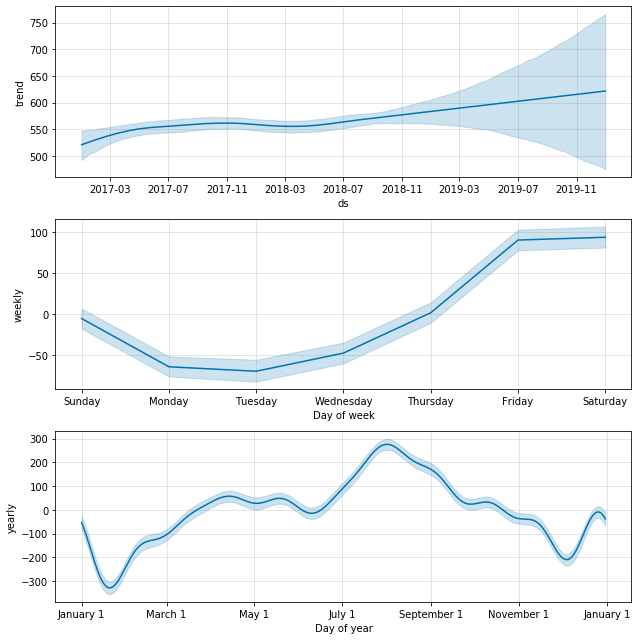

In [13]:
fig = m1.plot_components(forecast1)

The diagrams above display the trend, weekly and yearly seasonal components decomposed from the demand data along with its uncertainty intervals.

Let's have a look at the forecasted values. The diagrams below show the predictions of 2019 together with the demand data (ground truth). The model captures the seasonal components reasonably well and made a forecast for 2019 using the cyclic patterns in the previous years.

In [14]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m1, forecast1)  # This returns a plotly Figure
py.iplot(fig)

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

forecast1_filtered = forecast1[forecast1['ds'] >= '2019-01-01']

fig = make_subplots(specs=[[{"secondary_y": False}]])

fig = fig.add_trace(go.Scatter(x=forecast1_filtered['ds'], y=forecast1_filtered['yhat_lower'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               name=''))

fig = fig.add_trace(go.Scatter(x=forecast1_filtered['ds'], y=forecast1_filtered['yhat_upper'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               fillcolor='rgba(253, 180, 98, 0.3)',                               
                               fill='tonexty',
                               name='forecast bound'))

fig = fig.add_trace(go.Scatter(x=forecast1_filtered['ds'], y=forecast1_filtered['yhat'], 
                               mode='lines', 
                               line=dict(color='#ff7f0e'), 
                               fillcolor='rgba(253, 180, 98, 0.3)',
                               fill='tonexty',
                               name='forecast'))

fig = fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines+markers',                  
                               line=dict(color='#636efa', width=0.5),                               
                               marker=dict(size=4),
                               name='ground truth'))

fig.update_layout(title='Model 1 Forecasting (with demand data only)')

fig.show()

### Forecast accuracy (model 1)

The above diagram shows the forecasts for 2019 and the ground truth demand data. The forecasting model made a good prediction overall based on historical cyclic patterns. However, it failed to make accurate predictions on days with unexpected demands caused by events and holidays.

We will build a more sophisticated forecasting model with higher accuracy in the next section. To compare the model accuracy, here we compute the mean absolute percentage error (MAPE). It is a common metric for measuring the accuracy of forecasting models due to its interpretability.

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
mape = mean_absolute_percentage_error(test['y'].values, forecast1['yhat'][-365:])
print(f"Model 1's Mean Absolute Percentage Error: {mape:.2f}")

Model 1's Mean Absolute Percentage Error: 17.70


In the next section, we are going to build a forecasting model with higher accuracy (with over 7.31% improvement) that incorporates events data as a feature.

## Build a forecasting model with Aggregrate Event Impact and Holidays (model 2)
The forecasting model built using demand data only in the previous section is able to predict the overall demand based on the seasonal cycle reasonably well. But it cannot predict unexpected demand caused by events or holidays due to their irregular nature. Events are external sources of demand that most of our customers find difficult to forecast because they are not part of the standard seasonal trends that are captured by a standard demand forecasting model.

In this section, we are going to build a forecasting model that incorporates both PredictHQ’s Aggregate Event Impact and holiday data. Our aim is to train a forecasting model to be able to learn the relationship between demand and events data, so it can make more accurate demand forecasts.

A common step to add features into the forecasting model is to first identify the relationship between the demand data and the feature being added. This helps us to select the best forecasting model for the task. 

In this example, we assume you have identified correlation between your historical incremental demand and our Aggregate Event Impact data. If you have not had an opportunity to do this, we recommend following our <a href="https://docs.predicthq.com/datascience/correlation/">correlation guide</a> to do so. This will enable you to better understand the relationship, and give you insights on how we use Aggregate Event Impact data to train the forecasting model.

Prophet is a generalized additive model that can handle the relationship between demand and aggregate event impact data internally. So we do not need to explicitly extract incremental demand in this example. However, other types of demand forecasting models may require different data input or transformation. If you do have another type of model that needs incremental demand then in your training set include aggregate event impact and incremental demand per day.

First, let's load three years (2017 to 2019) of Aggregate Event Impact (AEI) data to a pandas dataframe. We have prepared this data in a CSV file as <i>aei_2017to2019.csv</i>. This file contains an export of AEI data for Seattle from 2017 to 2019.

In [18]:
# Load three years of AEI data
aei = pd.read_csv('https://raw.githubusercontent.com/predicthq/phq-data-science-docs/master/demand-forecasting/aei_2017to2019.csv', index_col=0)

We will be using the overall daily aggregated event impact across categories.

The data should look like the following:

In [19]:
aei.head()

count  aggregated_impact  community_count  concerts_count  \
2017-01-01      3              12000                1               0   
2017-01-02      1                  0                0               0   
2017-01-03      0                  0                0               0   
2017-01-04      1               6000                0               0   
2017-01-05      0                  0                0               0   

            festivals_count  performing-arts_count  sports_count  \
2017-01-01                0                      0             1   
2017-01-02                0                      0             0   
2017-01-03                0                      0             0   
2017-01-04                0                      0             1   
2017-01-05                0                      0             0   

            conferences_count  expos_count  public-holidays_count  ...  \
2017-01-01                  0            0                      1  ...   
2017-01-02                  0            0                      1  ...   
2017-01-03                  0            0                      0  ...   
2017-01-04                  0            0                      0  ...   
2017-01-05                  0            0                      0  ...   

            concerts_impact  festivals_impact  performing-arts_impact  \
2017-01-01                0                 0                       0   
2017-01-02                0                 0                       0   
2017-01-03                0                 0                       0   
2017-01-04                0                 0                       0   
2017-01-05                0                 0                       0   

            sports_impact  conferences_impact  expos_impact  \
2017-01-01           6000                   0             0   
2017-01-02              0                   0             0   
2017-01-03              0                   0             0   
2017-01-04           6000                   0             0   
2017-01-05              0                   0             0   

            public-holidays_impact  school-holidays_impact  \
2017-01-01                       0                       0   
2017-01-02                       0                       0   
2017-01-03                       0                       0   
2017-01-04                       0                       0   
2017-01-05                       0                       0   

            observances_impact  rescaled_aei  
2017-01-01                   0      0.029925  
2017-01-02                   0      0.000000  
2017-01-03                   0      0.000000  
2017-01-04                   0      0.014963  
2017-01-05                   0      0.000000  

[5 rows x 23 columns]

### Prepare aggregate event impact as training data and extra features data
Prophet allows 'additional regressors' to be added to the linear part of the model. Our additional regressor is our Aggregate Event Impact data and its value will need to be present in both the fitting and prediction dataframes.
Let’s split the first two years (2017 to 2018) of AEI data as training data and the last year (2019) as additional features in the prediction dataframe.

Note: in our example we are using a CSV file with Aggregate Event Impact data. You can get this data yourself using the <a href="https://predicthq.com/product/api/data/exporter">data exporter</a> to export aggregate event impact data for your locations. If you are following this guide for real in order to get a training set for your model follow our <a href="https://docs.predicthq.com/datascience/correlation/">correlation guide</a> and produce a CSV file with aggregate event impact data (and incremental demand data if your model uses it) and use that data for your training set.

In [20]:
# Select AEI between 2017 to 2018 as training data
aei_train_df = aei['2017-01-01':'2018-12-31']

In [21]:
# Add AEI as new column in the training dataframe
train['aei'] = aei_train_df['aggregated_impact'].values

The <i>train</i> dataframe now should look like this.

In [22]:
train.head()

ds           y    aei
0  2017-01-01  208.671460  12000
1  2017-01-02  173.002159      0
2  2017-01-03  231.782956      0
3  2017-01-04  240.631985   6000
4  2017-01-05  250.908314      0

## Adding Holiday effects to the forecasting model
We can model the impact of holidays and special events in Prophet by adding their occurrences for events from the past (back as far as the training data) and in the future (out as far as the forecast is being made). You can obtain different types of holiday information in our Aggregate Event Impact data and incorporate them into your model.  We recommend adding holidays as binary variables in your model. In the Aggregate Event Impact data there are three categories for holidays which are called the following in the CSV export: public-holidays_count, school-holidays_count and observances_count. These categories have a count of holidays for each day for the specified location. The count can be more than 1 if multiple holidays are happening on a given day. For the holiday category if the count is greater than or equal to 1 for a category then set the holiday binary variable to 1.

In this example, we cover two different types of holidays. 
 - Easters - happens at a different date every year (irregular pattern).
 - Christmas and New Year Eve - happens on the same date every year (regular pattern).

We can also specify a window that covers the effects of the holiday by the parameters <i>lower_window</i> and <i>upper_window</i>. The size of the windows around a specific holiday depends on the observation in the demand data as we showed in the previous section. An even better approach is to extract the incremental demand from the demand data like we have shown in the Correlation Guide.

In [23]:
# Build a dataframe for Easter between 2017 to 2019
# It covers up to three days before and two days after the specified date
easters = pd.DataFrame({
    'holiday': 'easter',
    'ds': pd.to_datetime(['2017-04-16', '2018-04-01', '2019-04-21']),
    'lower_window': -3,
    'upper_window': 2,
})

# Build a dataframe for Christmas between 2017 to 2019
# It covers up to three days before and three days after the specified date
xmas = pd.DataFrame({
    'holiday': 'xmas',
    'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25']),
    'lower_window': -3,
    'upper_window': 3,
})

# Build a dataframe for New Year Eve between 2017 to 2019
# It covers up to three days before and three days after the specified date
new_year_eve = pd.DataFrame({
    'holiday': 'new_year_eve',
    'ds': pd.to_datetime(['2017-12-31', '2018-12-31', '2019-12-31']),
    'lower_window': -3,
    'upper_window': 3,
})

# Put all three dataframe together into a single dataframe
holidays = pd.concat([easters, xmas, new_year_eve])

### Build and train the model with holidays and Aggregate Event Impact data
Now we initialize a Prophet model like the first model we built but with additional holidays dataframe as input and an additional regressor which carries the aggregate event impact data to the model.

We then train the model using the prepared training data. We set the parameters to decompose the yearly and weekly seasonality components from the demand data using an additive time series model. We will also be using Bayesian sampling specified by the <i>mcmc_samples</i> parameter. This will allow us to identify the uncertainty in seasonal components.

In [24]:
# Initialize a prophet model with parameters and holidays dataframe
m2 = Prophet(holidays=holidays, mcmc_samples=300, yearly_seasonality=True, 
             weekly_seasonality=True, daily_seasonality=False, 
             seasonality_mode='additive')
# Add a additional regressor containing AEI data
m2.add_regressor('aei', prior_scale=0.9, standardize=True, mode='additive')
# Train the model with the training data
m2.fit(train)

## Forecasting
We will make predictions for the entire year of 2019 with the forecasting model trained using data from 2017 to 2018 with holidays and AEI data.

We first create a dataframe with future dates for forecasting.

In [25]:
# Create the future dataframe with future dates
future2 = m2.make_future_dataframe(periods=365)
# Add AEI columns to the future dataframe
future2['aei'] = aei['aggregated_impact'].values

### Make predictions
Here we make predictions and the results are stored in the forecast dataframe.

In [26]:
# Make predictions
forecast2 = m2.predict(future2)

The forecasted values are stored in the yhat column and the lower bound and upper bound values are stored in the yhat_lower and yhat_upper columns respectively.

In [27]:
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
1090 2019-12-27  892.858663  739.163077  1048.111355
1091 2019-12-28  762.248899  601.407733   927.875496
1092 2019-12-29  627.761891  461.256789   799.174357
1093 2019-12-30  860.683025  693.543409  1023.644648
1094 2019-12-31  779.350213  619.746474   940.145134

There are also other columns including the decomposed components and its uncertainty intervals in the forecast dataframe. This model also includes the effects of holidays and the extra regressor (with AEI data) information.

Let's visualize the decomposed components using the Prophet's built-in function.

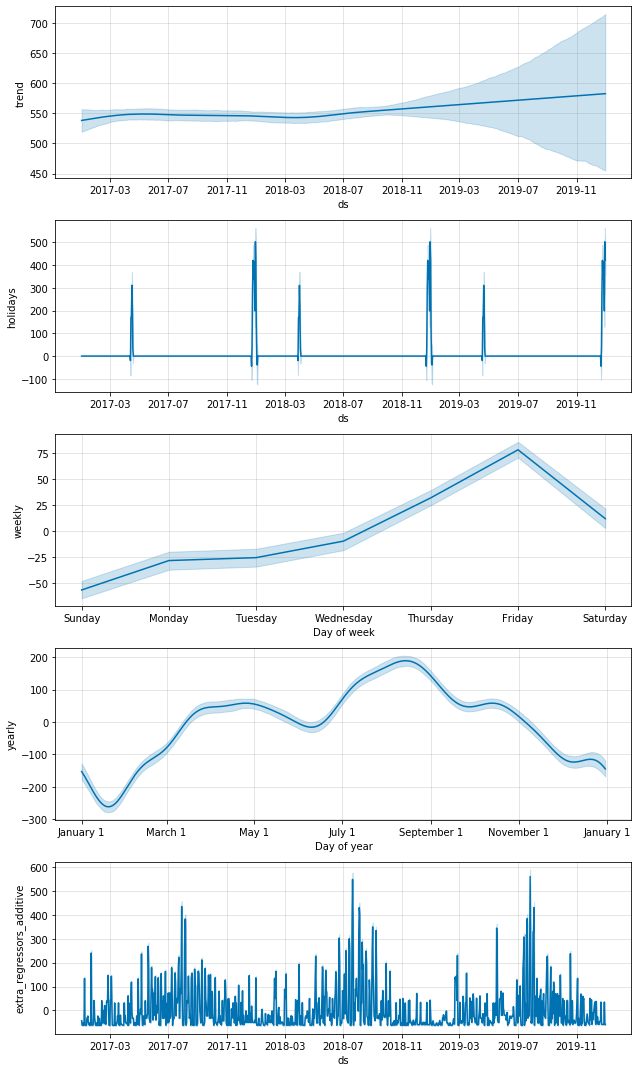

In [28]:
fig = m2.plot_components(forecast2)

The diagram above shows not only the trend, weekly and yearly seasonal components decomposed by the model, but also the effects of holidays and aggregate event impact data as extra_regressors_additive in the model.

Let's have a look at the forecasted values in the diagram below. The diagrams below show the predictions of 2019 together with the demand data (ground truth). Compared with Model 1 using only demand data, the prediction more closely reflects the demand data.

This model is able to make more accurate predictions on demand caused by events and irregular holidays which cannot be captured with seasonal effects alone.

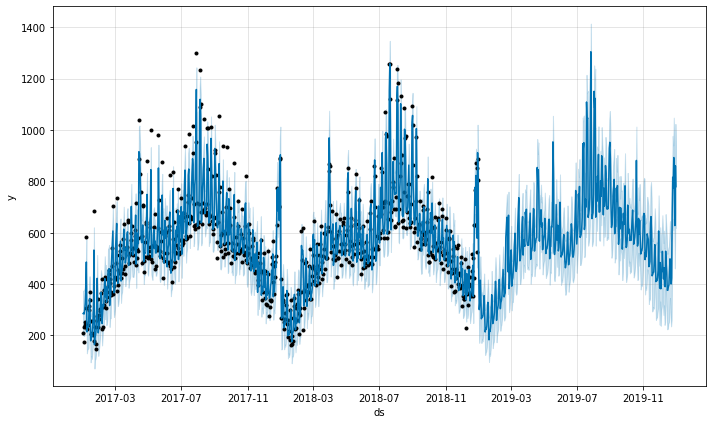

In [29]:
fig = m2.plot(forecast2)

Let's take a closer look at the predictions.

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

forecast2_filtered = forecast2[forecast2['ds'] >= '2019-01-01']
forecast1_filtered = forecast1[forecast1['ds'] >= '2019-01-01']

fig = make_subplots(specs=[[{"secondary_y": False}]])

fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat_lower'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               name=''))

fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat_upper'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               fillcolor='rgba(231, 138, 195, 0.3)',                               
                               fill='tonexty',
                               name='forecast bound (model 2)'))

fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat'], 
                               mode='lines', 
                               line=dict(color='rgb(231, 41, 138)'), 
                               fillcolor='rgba(231, 138, 195, 0.3)',                               
                               fill='tonexty',
                               name='forecast with aei (model 2)'))

fig = fig.add_trace(go.Scatter(x=forecast1_filtered['ds'], y=forecast1_filtered['yhat'], 
                               line=dict(color='#ff7f0e', width=1.0), 
                               name='forecast without aei (model 1)'))

fig = fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines+markers',                                
                               line=dict(color='#636efa', width=0.5),                   
                               marker=dict(size=4),                               
                               name='ground truth'))

fig.update_layout(title='Model 2 Forecasting (with AEI and holidays)')

fig.show()

### Forecast accuracy (model 2)

The above diagram shows Model 2's forecasts for 2019, the ground truth demand data and also Model 1's forecast values for comparison.

The prediction in Model 2 is much closer to the ground truth especially on days with unexpected demand caused by events and holidays.

Let's take a closer look at some examples.

Prepare annotations for specific dates as an example.

In [31]:
# Here we select two dates as an example
date_examples = ['2019-04-21', '2019-05-18']
date_examples_labels = ['Easter', 'Demand caused by events']
annotations_offset = [[-20,-80,+40,-60,-5,+65],[-20,-70,+40,-70,-5,+100]]

In [32]:
# Prepare annotations
four_test_annotations = [dict(x=date, y=test[test['ds']==date]['y'].values[0], 
                              xref='x', yref='y', 
                              font=dict(color='blue'), 
                              text=f'{label}<br>ground truth', 
                              ax=offset[0], ay=offset[1])  
                         for date, label, offset in zip(date_examples, date_examples_labels, annotations_offset)]

four_forecast2_annotations = [dict(x=date, y=forecast2_filtered[forecast2_filtered['ds']==date]['yhat'].values[0], 
                                   xref='x', yref='y', 
                                   font=dict(color='red'), 
                                   text='model with AEI',
                                   ax=offset[2], ay=offset[3])
                              for date, offset in zip(date_examples, annotations_offset)]

four_forecast1_annotations = [dict(x=date, y=forecast1_filtered[forecast1_filtered['ds']==date]['yhat'].values[0], 
                                   xref='x', yref='y', 
                                   font=dict(color='rgb(230, 131, 16)'), 
                                   text='model without AEI', 
                                   ax=offset[4], ay=offset[5])   
                              for date, offset in zip(date_examples, annotations_offset)]

four_annotations = four_test_annotations + four_forecast2_annotations + four_forecast1_annotations

Plot the example date with annotations.

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

forecast2_filtered = forecast2[(forecast2['ds'] >= '2019-04-01') & (forecast2['ds'] <= '2019-06-10')]
forecast1_filtered = forecast1[(forecast1['ds'] >= '2019-04-01') & (forecast1['ds'] <= '2019-06-10')]
test_filtered = test[(test['ds'] >= '2019-04-01') & (test['ds'] <= '2019-06-10')]

fig = make_subplots(specs=[[{"secondary_y": False}]])

fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat_lower'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               name=''))

fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat_upper'], 
                               mode='lines', 
                               marker=dict(color="#444"), 
                               line=dict(width=0), 
                               fillcolor='rgba(231, 138, 195, 0.3)',                               
                               fill='tonexty',
                               name='forecast bound (model 2)'))
fig = fig.add_trace(go.Scatter(x=forecast2_filtered['ds'], y=forecast2_filtered['yhat'], 
                               mode='lines', 
                               line=dict(color='rgb(231, 41, 138)'), 
                               fillcolor='rgba(231, 138, 195, 0.3)',                               
                               fill='tonexty',
                               name='forecast with aei (model 2)'))

fig = fig.add_trace(go.Scatter(x=forecast1_filtered['ds'], y=forecast1_filtered['yhat'], 
                               line=dict(color='#ff7f0e', width=1.0), 
                               name='forecast without aei (model 1)'))

fig = fig.add_trace(go.Scatter(x=test_filtered['ds'], y=test_filtered['y'], mode='lines+markers',                                
                               line=dict(color='#636efa', width=0.5),                   
                               marker=dict(size=4),                               
                               name='ground truth'))

fig.update_layout(title='Model 2 Forecasting (with AEI and holidays)')
fig.update_layout(annotations=four_annotations)

fig.show()

The above diagram shows two specific dates as examples.

The first unexpected demand spike is caused by the Easter holiday which happens on a different date each year. Model 2 successfully makes accurate predictions using historical Easter holidays and demand data. It learned the relationship between changes in demand and the Easter holidays.

The second unexpected demand spike is caused by events that are hard to predict using demand data alone due to the nature of the irregularities of events. Model 2 also successfully makes accurate predictions with the added AEI data. It learned the relationship between AEI and the demand from historical data and adjusted the prediction.

Let's compare the two model's accuracy using MAPE.

In [34]:
mape = mean_absolute_percentage_error(test['y'].values, forecast1['yhat'][-365:])
print(f"Model 1's Mean Absolute Percentage Error: {mape:.2f}")

mape = mean_absolute_percentage_error(test['y'].values, forecast2['yhat'][-365:])
print(f"Model 2's Mean Absolute Percentage Error: {mape:.2f}")

Model 1's Mean Absolute Percentage Error: 17.70
Model 2's Mean Absolute Percentage Error: 10.39


There is a 7.31% improvement with our forecasting accuracy using MAPE as the metric. However, there are many other ways to measure the accuracy of a forecasting model. One may need to decide the best metric based on your data and model.

### Cross-validation on model forecast accuracy

Prophet provides a more advanced method to evaluate the accuracy of a forecasting model. It uses simulated historical forecasts by producing multiple forecasts at various cutoff points in history. The chosen horizons lie within the history and therefore the total error can be evaluated. Please refer to <a href="https://peerj.com/preprints/3190.pdf">this paper</a> for in-depth details.

In [35]:
from fbprophet.diagnostics import cross_validation
# Set the horizon to be 180 days
df_cv = cross_validation(m2, horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-07-04 00:00:00 and 2018-07-04 00:00:00


ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2018-07-05  624.148682  542.821513  712.389038  674.719258 2018-07-04
1 2018-07-06  673.364012  583.531997  763.868491  719.040872 2018-07-04
2 2018-07-07  900.956277  811.412668  995.176575  837.072610 2018-07-04
3 2018-07-08  607.091926  523.501822  690.568218  699.566585 2018-07-04
4 2018-07-09  574.715420  485.987438  660.336807  612.418883 2018-07-04

We can also use Prophet's build-in functions to compute different performance metrics for each validation.

In [36]:
from fbprophet.diagnostics import performance_metrics
# Here we use Prophet's build-in functions to compute different metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon          mse       rmse        mae      mape  coverage
0 18 days  8952.702956  94.618724  77.558327  0.091641  0.611111
1 19 days  8965.962010  94.688764  77.686498  0.092011  0.611111
2 20 days  8850.685590  94.078082  75.336472  0.088758  0.611111
3 21 days  8659.411641  93.055960  73.190849  0.086454  0.611111
4 22 days  9096.926406  95.377809  75.173768  0.088034  0.611111

Here we plot a performance metric (MAPE) vs. forecast horizon from cross validation.

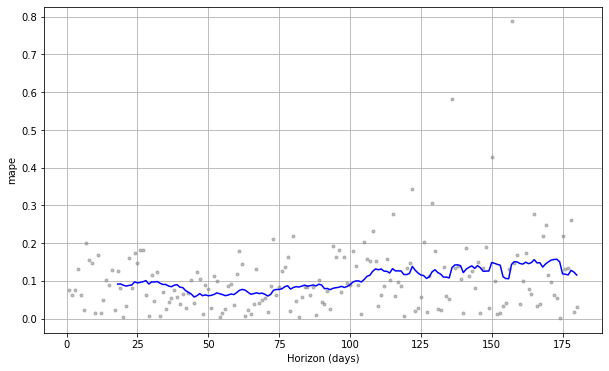

In [37]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Let's find out the horizon with the minimum MAPE.

In [38]:
df_p.loc[df_p['mape'] == df_p['mape'].min()]

horizon          mse       rmse        mae      mape  coverage
27 45 days  4477.291357  66.912565  53.588125  0.057477  0.833333

The above table shows the minimum MAPE on average of 5.7% with the horizon equal to 45 days. It means on average we can get the most accurate forecast result when we predict up to 45 days to the future. The best horizon number is dependent on your data and your model. It is also affected by the choice of forecasting strategy, such as sliding windows vs. expanding windows, and other factors.

## Adding features to your model based on Aggregate Event Impact
In this guide we use the total aggregate event impact as a feature in the model above. Below is a table listing the different aggregate event impact values and how you can use them in your model. 

| Columns names in export | Description |
| --- | :--- |
| aggregated_impact | Total aggregate event impact for all events on this day. If you want more granular features see the impact values per category below which break the impact out to show impact for each of the 7 categories covered. So rather than one feature for total impact you could have a feature for sports, another feature for conferences and another for expos, etc. |
| public-holidays_count | Can be used as a binary variable to indicate if a public holiday is present on a given day. |
| school-holidays_count | Can be used as a binary variable |
| observances_count | Can be used as a binary variable |
| community_impact | Impact for the community category only |
| concerts_impact | Impact for the concerts category only |
| festivals_impact | Impact for the festivals category only |
| performing-arts_impact | Impact for the performing arts category only |
| sports_impact | Impact for the sports category only |
| conferences_impact | Impact for the conferences category only |
| expos_impact | Impact for the expos category only |

When you export data with the <a href="https://exporter.predicthq.com/">Data Exporter</a> the above values are the name of the columns in the export. If you are using our API see the <a href="https://docs.predicthq.com/resources/events/">Aggregate Event Impact endpoint</a> (see Retrieve Aggregate Event Impact). Total impact is “impact”, impact per category is part of “categories_impact” and counts per category are under “categories” in the JSON response.

# Next steps
This guide is an example of how to add features that use event impact to your model. We provide an example data set and open source model as guidance. The next step is to try this with your own demand forecasting model and  data.

The sample data referenced in this guide uses CSV files with example demand and example Aggregate Impact data. To add features to your own demand forecasting model replace the example demand data with your own demand data. Then you can export Aggregate Event Impact data for the location you are using with our <a href="https://exporter.predicthq.com/">data exporter</a> in your forecast and use that to replace the sample in this guide.

To get access to our data if you haven’t already, please sign up for a <a href="https://signup.predicthq.com/?utm_source=ds_docs_demand_forecasting">developer plan</a>. This will grant you access to our API, <a href="https://exporter.predicthq.com/">Data Exporter</a>, <a href="https://predicthq.com/product/control-center">Control Center</a> and other tools. With those, you can take a deeper look at specific categories, rank levels, different time periods or other aspects of our data. This Developer Plan is limited to Seattle to get you started, but if you would like to access different cities or other locations, please <a href="https://predicthq.com/contact/sales?utm_source=ds_docs_demand_forecasting">talk to us</a>.

To update your demand forecasting in your production environment use <a href="https://developer.predicthq.com/">our API</a> to pull information on events and event impact. Integrate calls to the <a href="https://docs.predicthq.com/resources/events/">Aggregate Event Impact endpoint</a> (see Retrieve Aggregate Event Impact) to get data for a future period and then pass the data to your model in order to update your forecast in real time.

If you are not sure what to do next or want help integrating our API calls into your system please <a href="https://predicthq.com/contact/sales?utm_source=ds_docs_demand_forecasting">talk to our team of experts</a>.